In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap

import lab.functions as func
from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


In [5]:
lags = [2, 12, 23, 24, 36, 71, 72, 167, 168]
date_features = ["hour", "day", "day_of_week"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/hourly/"

In [6]:
def load_and_preprocess_daily_data(start_index, end_index, lags, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index)
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    train_test_division = math.floor(0.2*len(df_date_features))
    data_train = df_date_features.iloc[:-train_test_division, :].copy()
    data_test = df_date_features.iloc[-train_test_division:, :].copy()

    data_train_iso, data_test_iso = func.remove_outliers_isolation_forests_train_test(data_train, data_test, columns=[column for column in data_train.columns if column not in date_features])

    return data_train_iso, data_test_iso

## Prepandemic

In [7]:
save_name="hourly_pre.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

In [8]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
start_index="2018-10-01 00:00"
end_index="2019-03-31 23:59"

print(best_model_string)

RandomForestRegressor


### All predictors

In [9]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=lags, date_features=date_features)

In [10]:
shap_values_prepandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 0.6750706616259955


Permutation explainer: 841it [06:42,  2.03it/s]                         


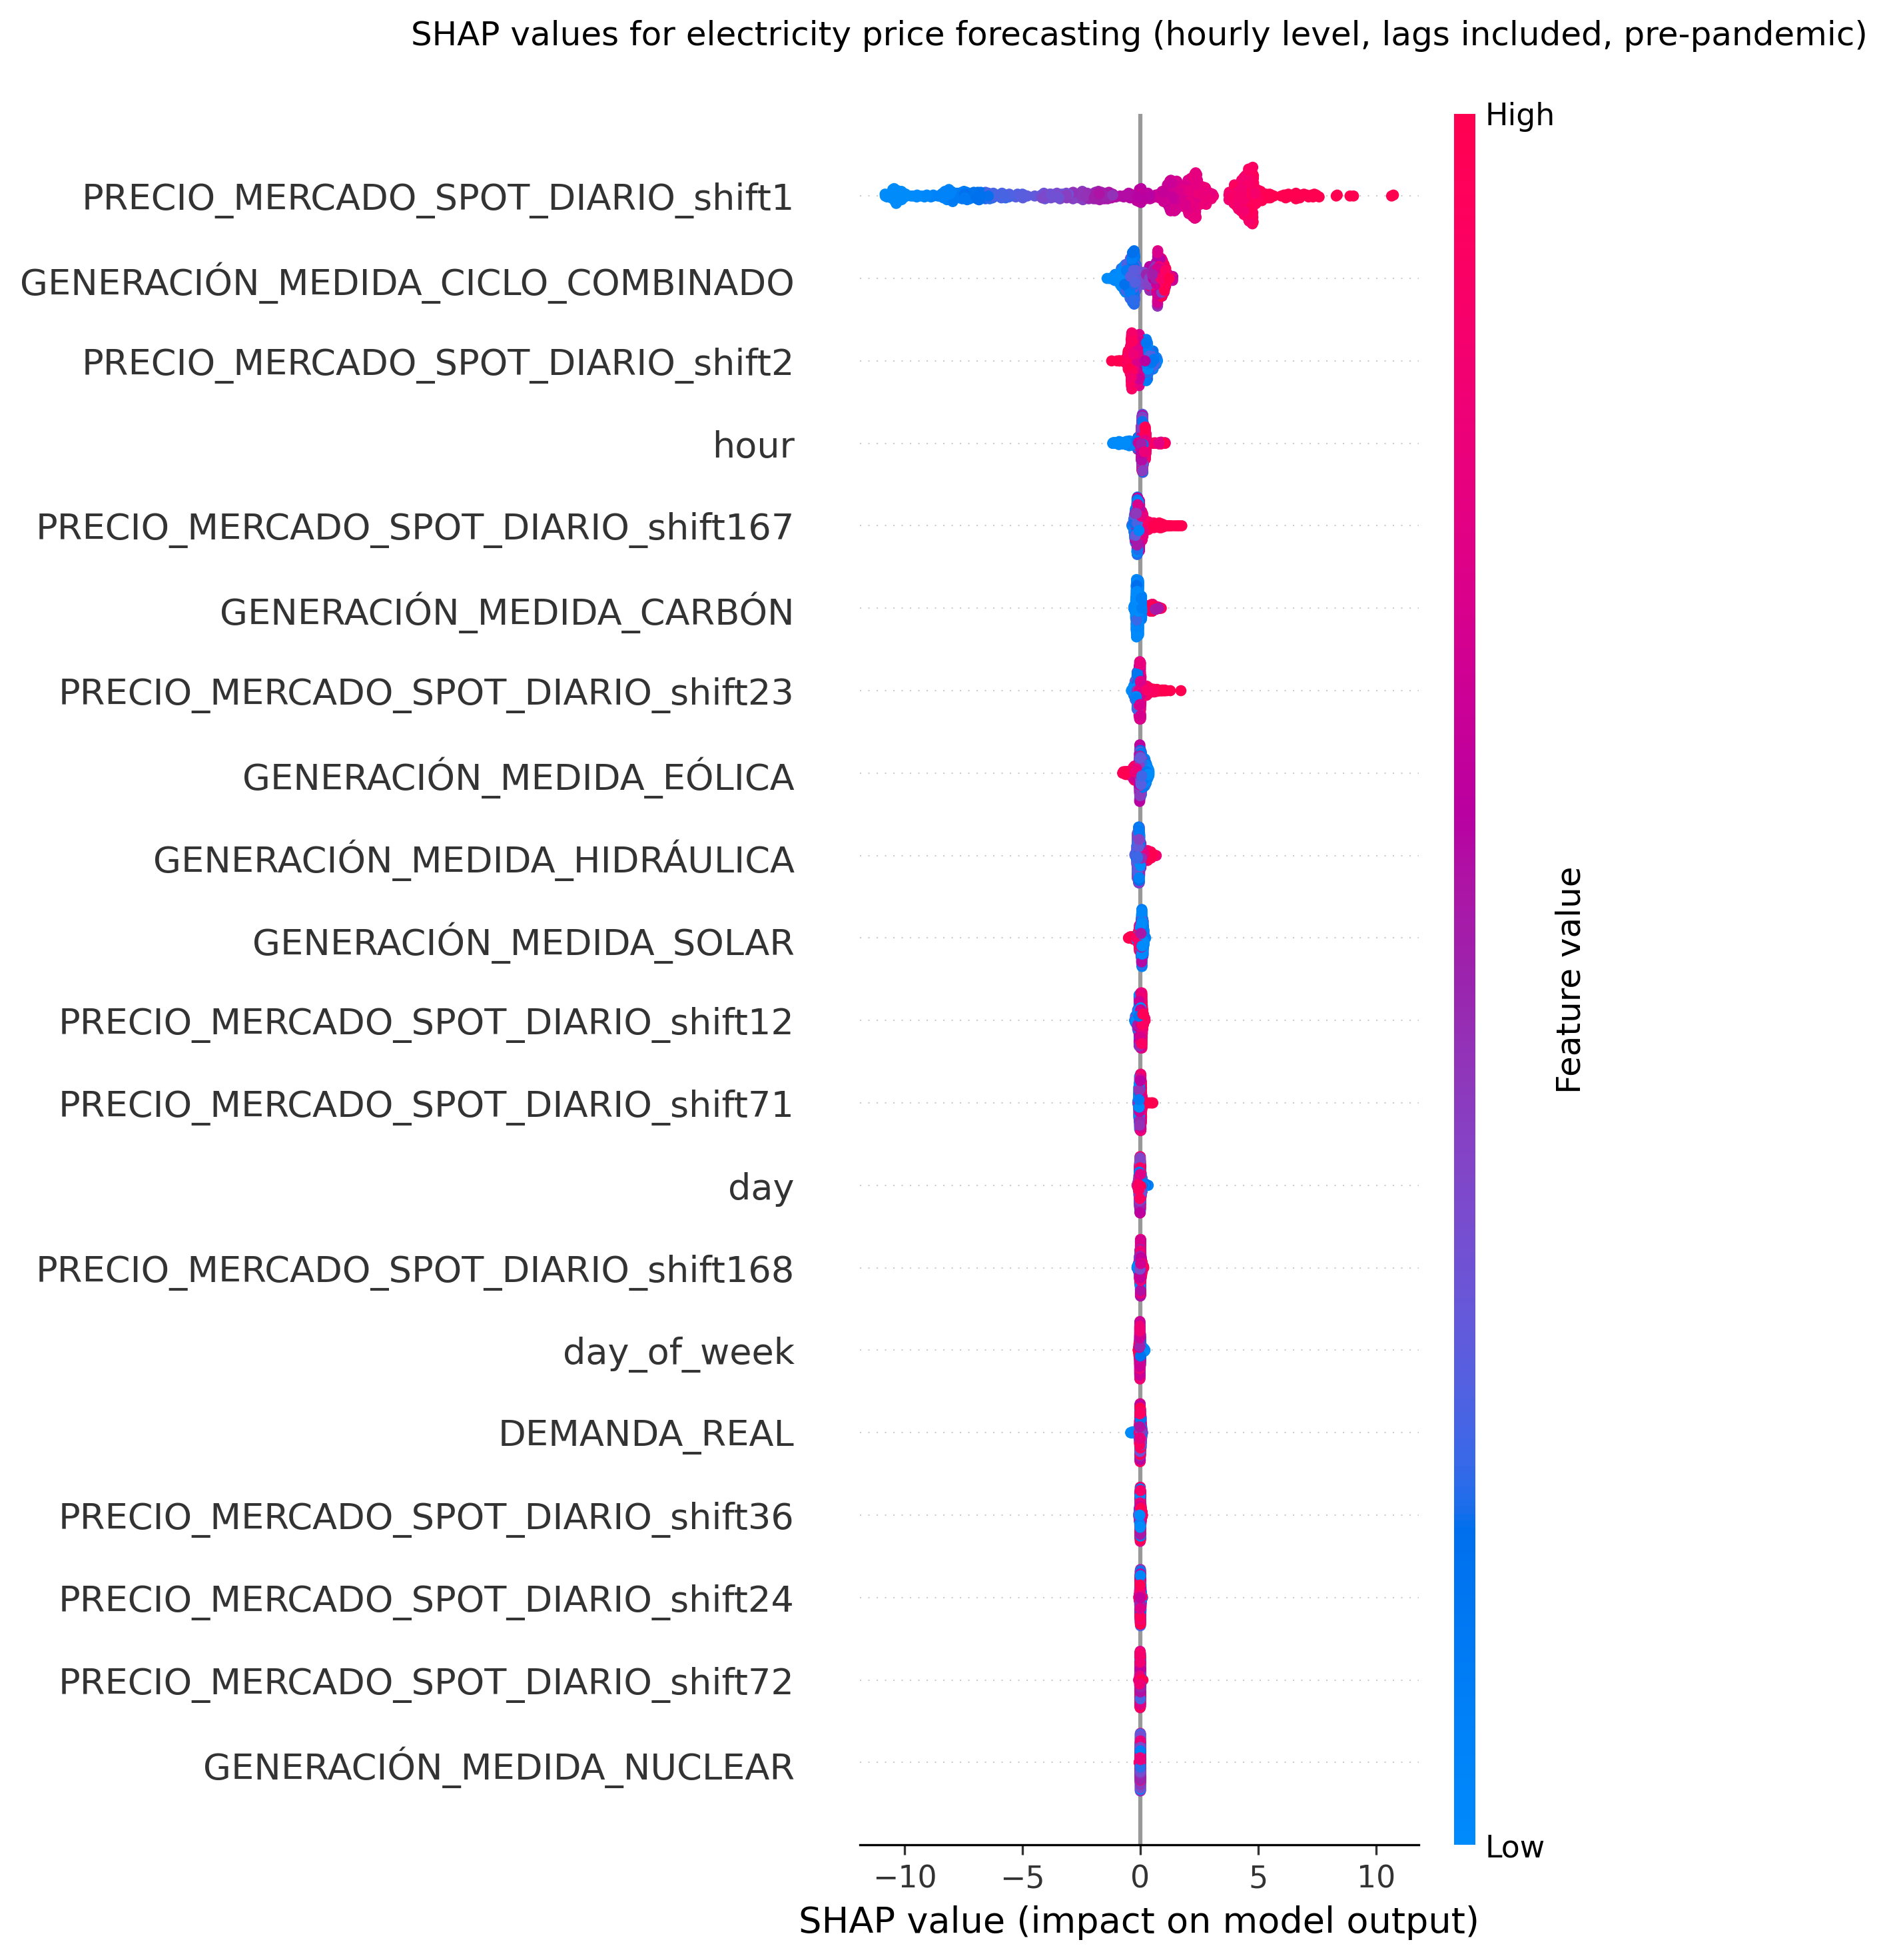

In [11]:
shap.summary_plot(shap_values_prepandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, lags included, pre-pandemic)", y=1.03)
plt.show()

### No lags

In [12]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=[], date_features=date_features)

In [13]:
shap_values_nolags_prepandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 2.9372854738249576


Exact explainer: 874it [03:15,  4.25it/s]                         


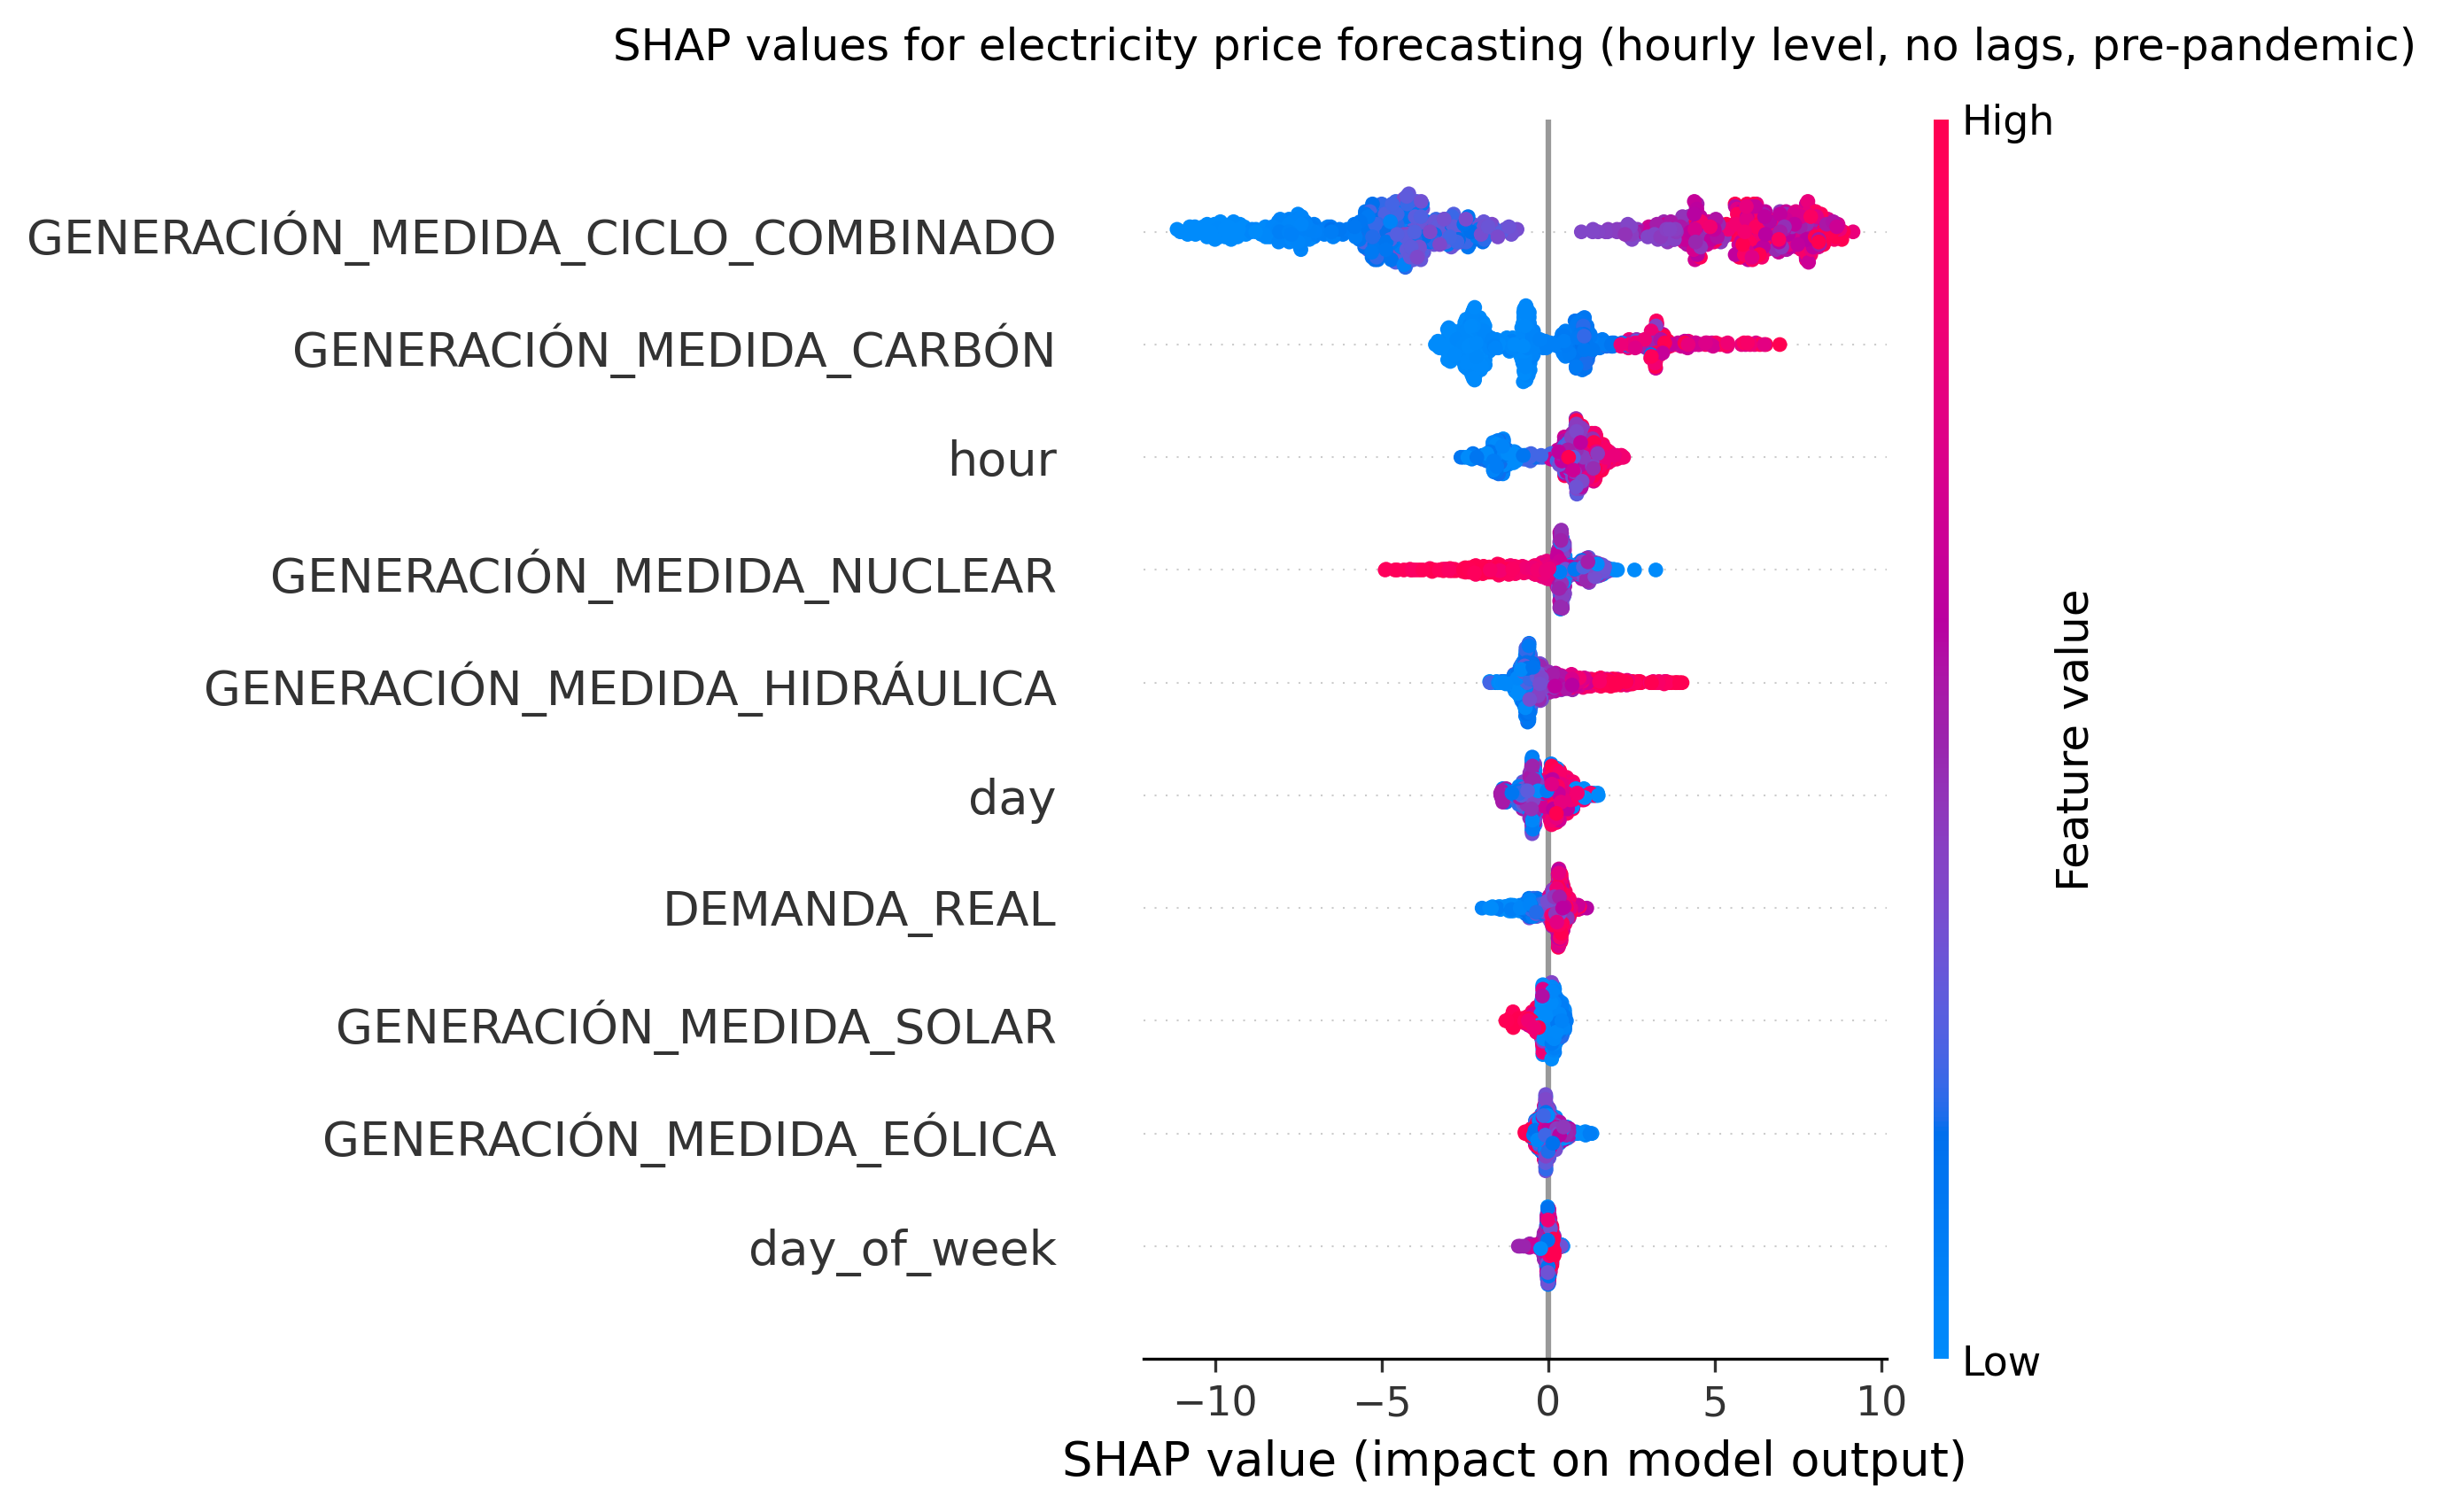

In [14]:
shap.summary_plot(shap_values_nolags_prepandemic, show=False)
plt.title(f"SHAP values for electricity price forecasting (hourly level, no lags, pre-pandemic)", y=1.03)
plt.show()

## Postpandemic

In [15]:
save_name="hourly_post.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

In [16]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
start_index="2022-10-01 00:00"
end_index="2023-03-31 23:59"

print(best_model_string)

RandomForestRegressor


### All predictors

In [17]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=lags, date_features=date_features)

In [18]:
shap_values_postpandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 0.8829407670274946


Permutation explainer: 841it [05:47,  2.35it/s]                         


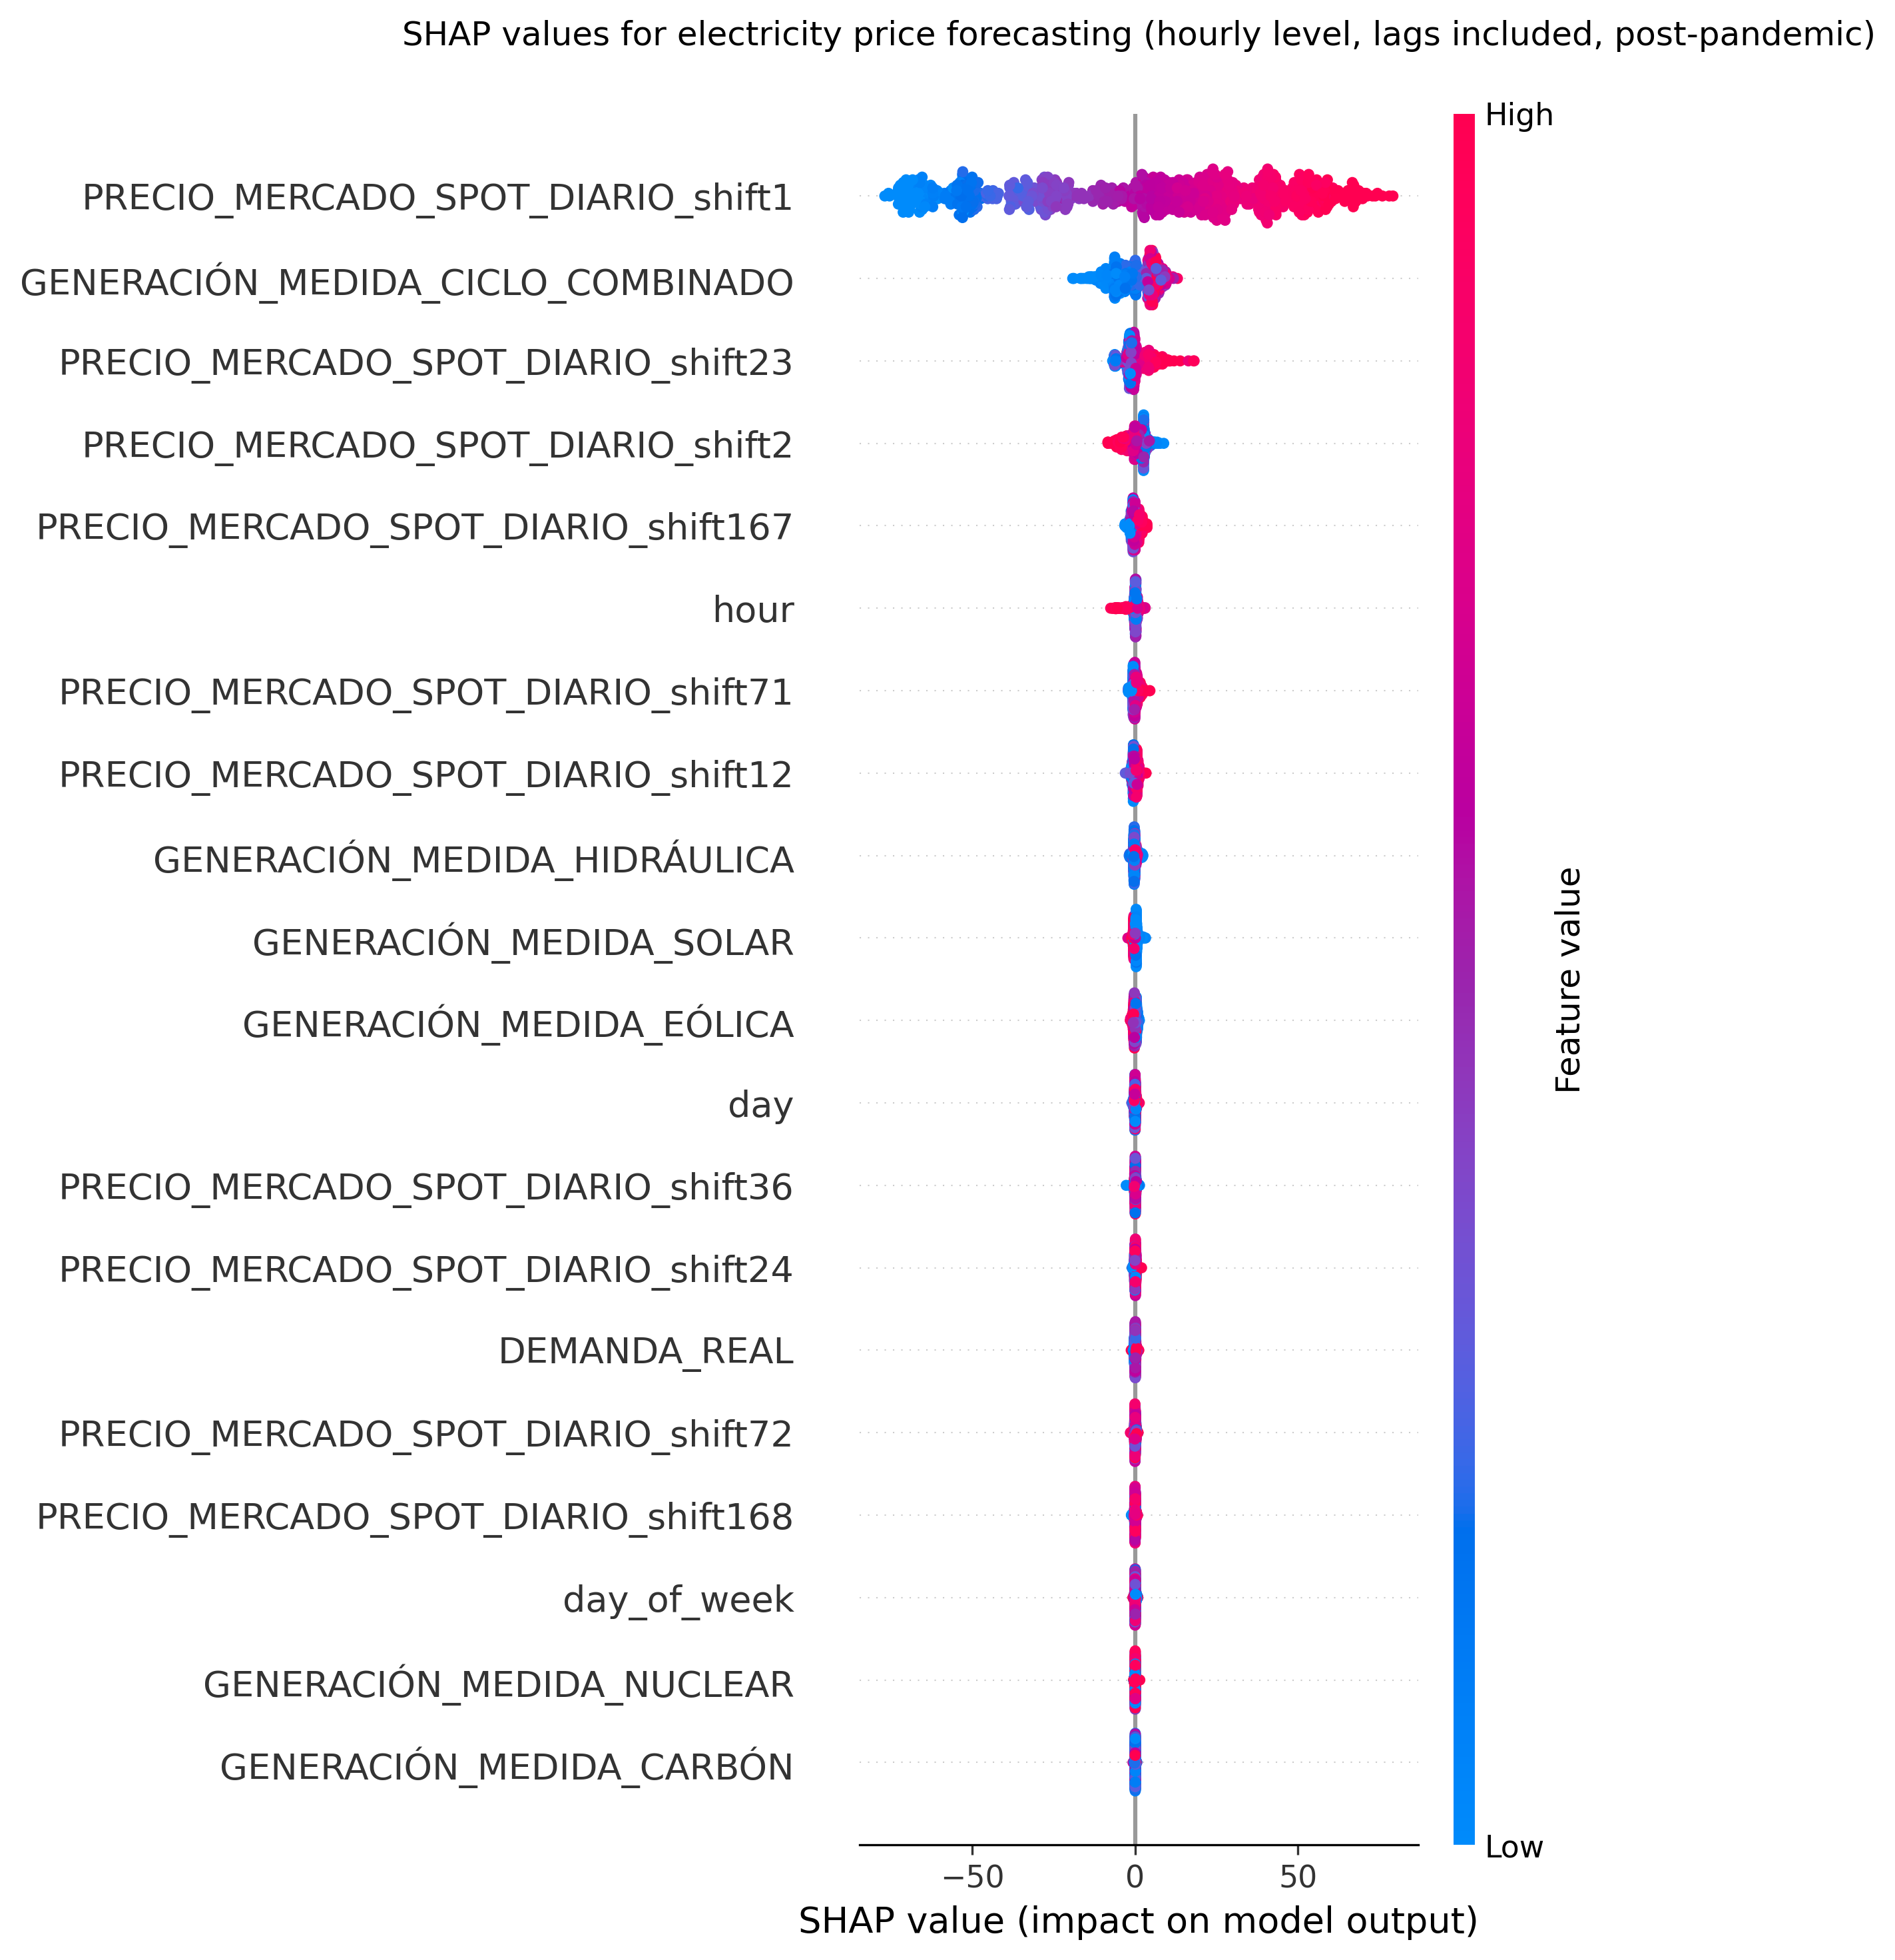

In [19]:
shap.summary_plot(shap_values_postpandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, lags included, post-pandemic)", y=1.03)
plt.show()

### No lags

In [20]:
data_train, data_test = load_and_preprocess_daily_data(start_index, end_index, lags=[], date_features=date_features)

In [21]:
shap_values_nolags_postpandemic = func.predictors_influence_study(data_train, data_test, best_model)

Prediction MASE: 2.10533906191979


Exact explainer: 874it [05:14,  2.67it/s]                         


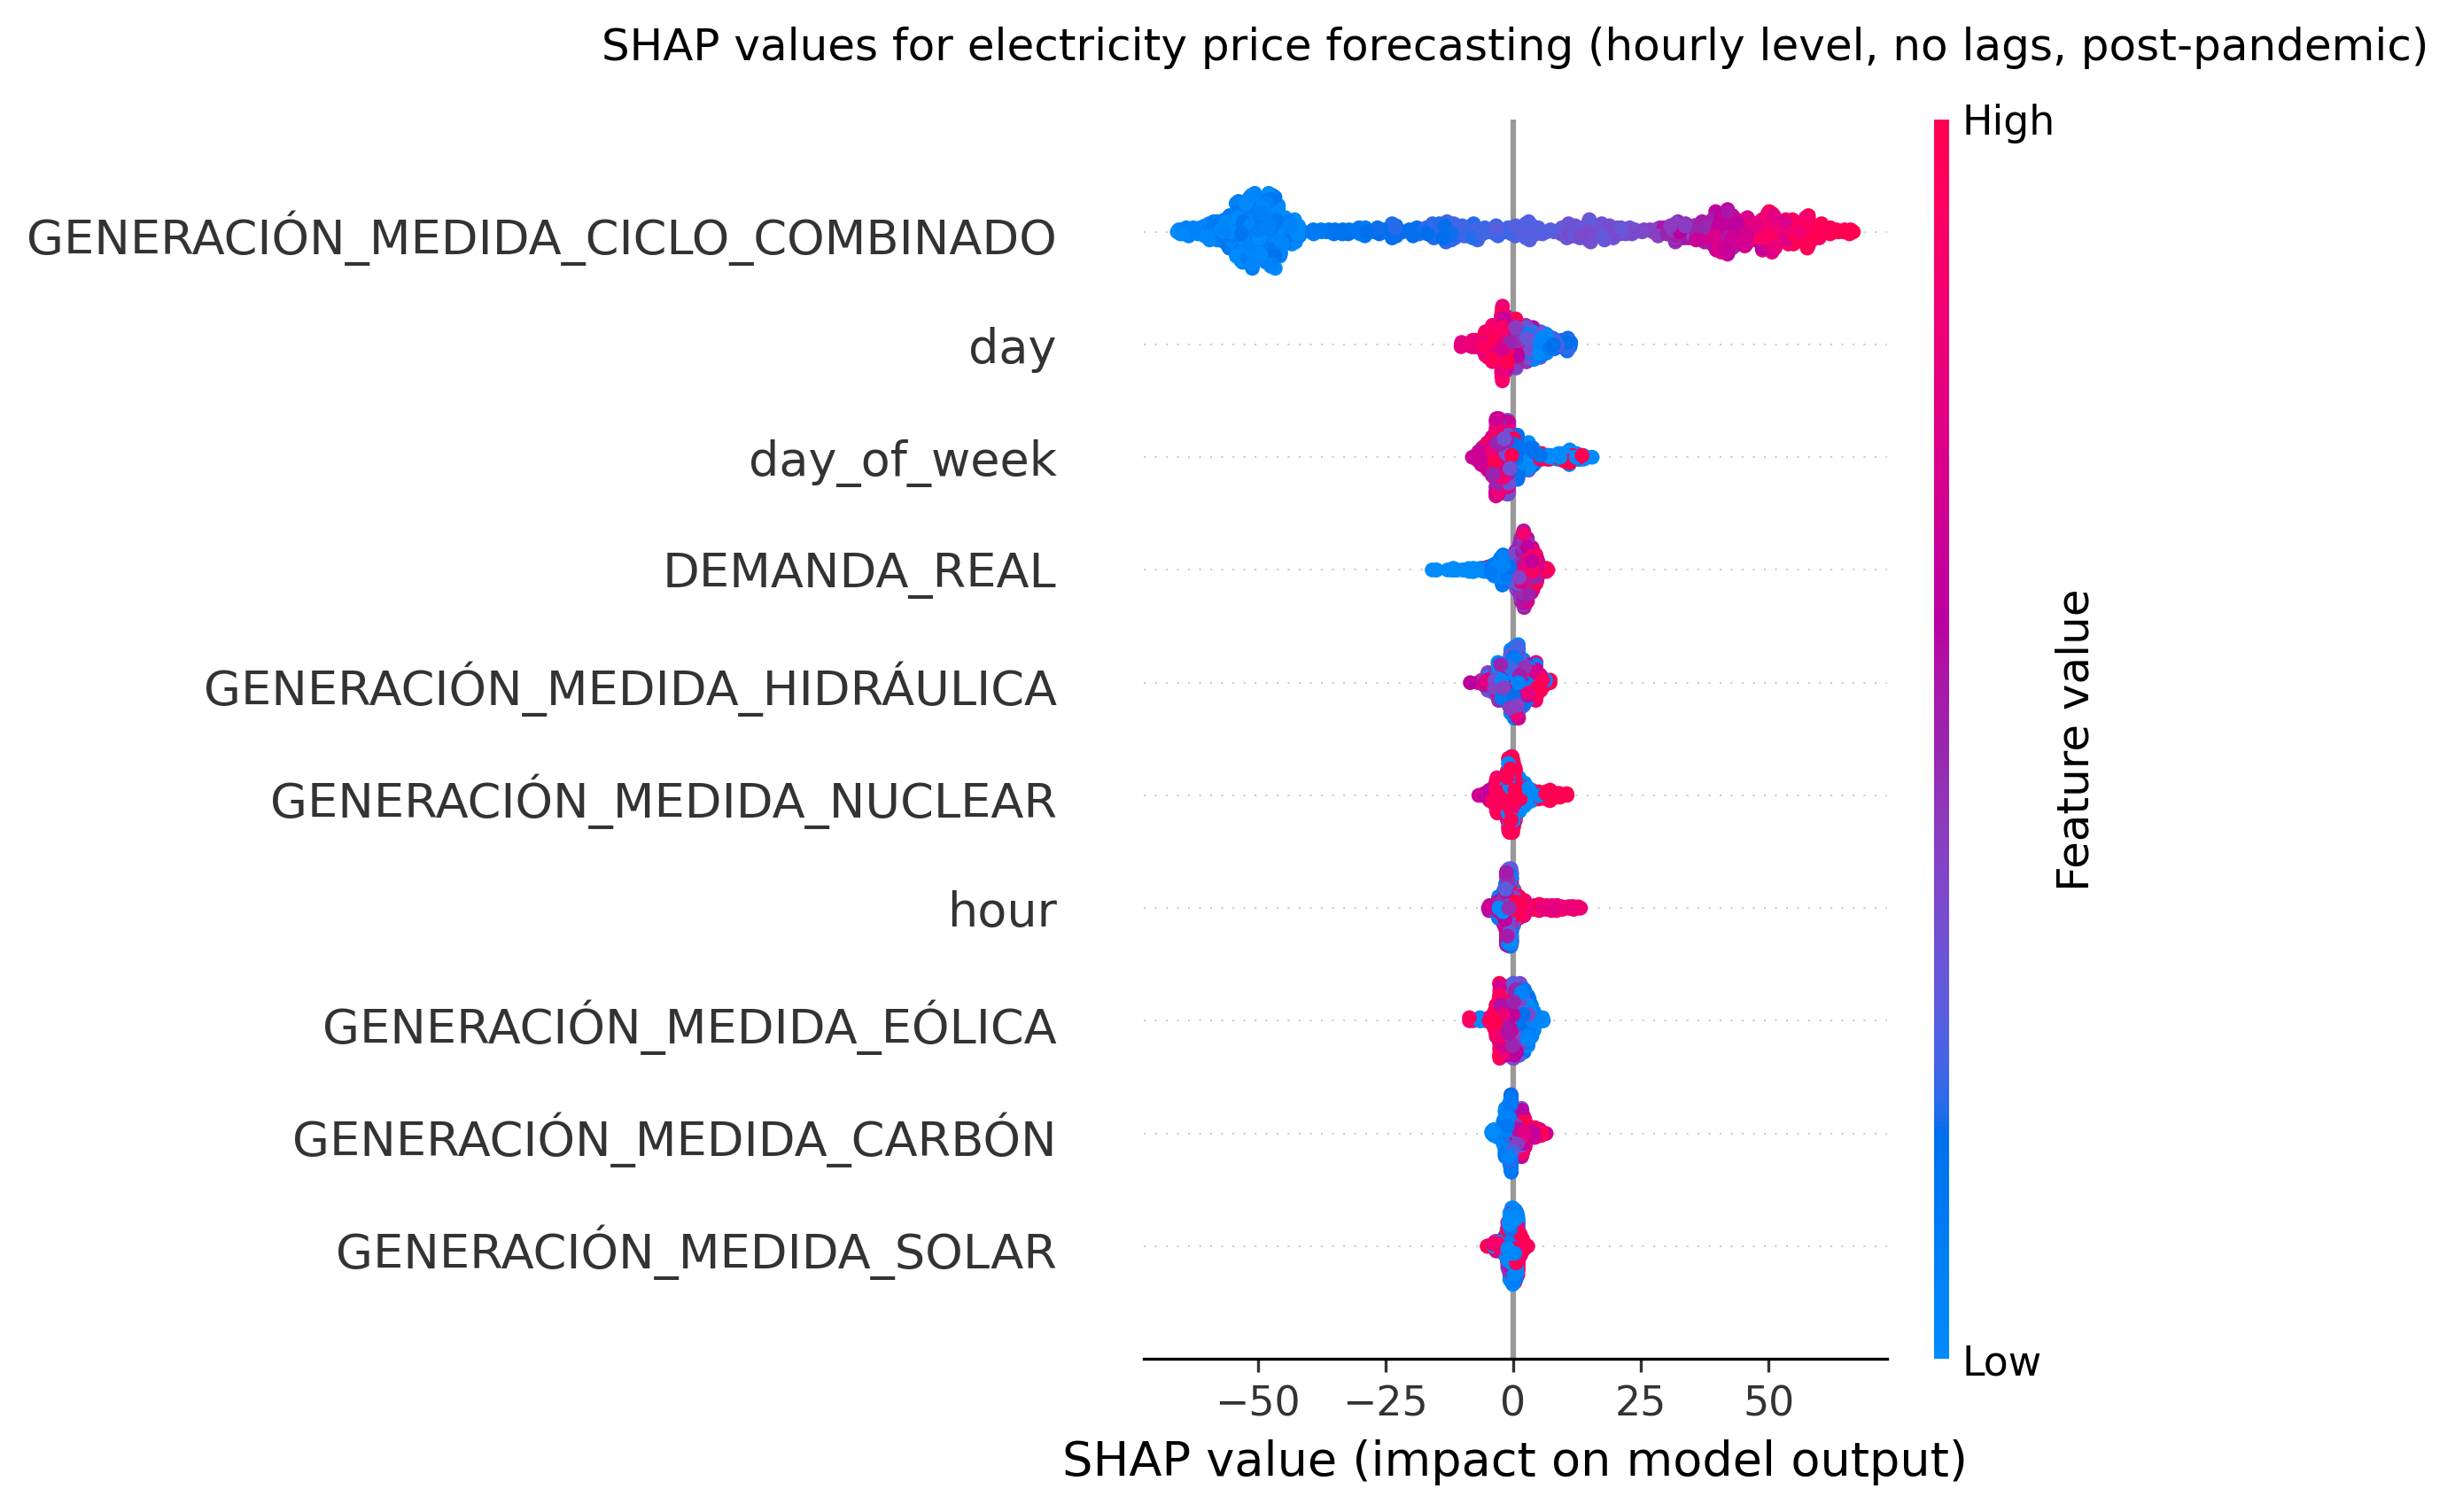

In [22]:
shap.summary_plot(shap_values_nolags_postpandemic, show=False)
plt.title("SHAP values for electricity price forecasting (hourly level, no lags, post-pandemic)", y=1.03)
plt.show()